# CI width by changing sample size for QMC and IID Beta for the Hedged (Betting) CI Method

[This JRSSB article by Ian Waudby-Smith and Aaditya Ramdas](https://academic.oup.com/jrsssb/article/86/1/1/7043257) takes $X_1, X_2, \ldots \stackrel{\text{IID}}{\sim} F$ and computes a sequential confidence interval for $\mu = \mathbb{E}(X)$.

For Quasi-Monte Carlo (QMC), also know as low discrepancy sequences, we are going to take 

$$
X_i = \frac{1}{m} \sum_{j=1}^m T_{ij},
$$ 

where for each $i$, $\{T_{ij}\}_{j=1}^m$ is a QMC set that mimics $F$. Therefore, $X_i$ is close to $\mu$, and the sequence $\{X_i\}_{i=1}^n$ is an IID sequence based on $N = mn$ samples.

In this notebook, $F$ is a Beta Distribution.


Similarly, for QMC, for $Y = f(X)$ where $X \sim U(0, 1)$ and $\mu = \mathbb{E}(Y) = \mathbb{E}(f(X))$, we are going to take

$$
Y_i = \frac{1}{m} \sum_{j=1}^m f(x_{ij})
$$ 

Therefore, $Y_i$ is close to $\mu$, and the sequence $\{Y_i\}_{i=1}^n$ is an IID sequence based on $N = mn$ samples. 

In this notebook, $Y = f(X) = \frac{X e^X}{e}$. 

We have used DigitalNetB2 (Sobol) for QMC and refer to $m$ as gen_samples and $n$ as spawn_samples.

Importing the necessary modules:

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import beta
from confseq.betting import betting_ci_seq
from confseq.predmix import predmix_empbern_ci_seq
import qmcpy as qp
import math

The parameters used for our numerical experiments

In [26]:
alpha = 0.05 # Significance level, confidence level = 1 - alpha

# parameteres used for the beta distribution simulations

beta_param = np.array([10,30]) #parameters for the beta distribution

# parameters used for the integrand problem

f = lambda x: x*np.exp(x)/np.exp(1) # the integrand function

# parameters used for the beta distribution and integrand problem

# parameters used when spawn_samples and gen_samples are not being varied

num_times = 100  #number of different times where CI will be computed
space_times = 1
    #space between different times where CI will be computed for the IID_QMC_Beta samples. For IID_Beta, space between different times equals gen_samples * space_times
spawn_samples = num_times*space_times # The number of IID replications for low discrepancy or QMC samples (n)
gen_samples = 2**5 # The number of low discrepancy or QMC samples generated per replication (m)
N = spawn_samples * gen_samples # The maxmimum sample size (N = mn)

# parameters used when spawn_samples and gen_samples are being varied but their product is kept constant.

N_vary = 2**10 # The maximum sample size to be used. Recommended to keep a power of 2 since gen_samples must be a power of 2 (QMC rules).
gen_samples_vary = 2 ** np.arange(0, int(math.log2(N_vary)) + 1) # The vector of number of low discrepancy or QMC samples generated per replication (m)
spawn_samples_vary = N_vary // gen_samples_vary # The vector of number of IID replications for low discrepancy or QMC samples (n)


# Using Beta Distibution:

## Not varying the spawn_samples(n) or gen_samples(m)

The plot function used for both the IID_Beta and IID_QMC_Beta experiments:

In [27]:
def plot_func(times,lower_bound,upper_bound, title):
    fig, axs = plt.subplots(1, 2)
    axs[0].plot(times,lower_bound, color = "red")
    axs[0].plot(times,upper_bound, color = "red")
    axs[0].axhline(y=0.25, color="blue", linestyle="--")
    axs[1].plot(times,upper_bound - lower_bound, color = "red")
    axs[0].set_xlabel("sample size N") 
    axs[0].set_ylabel("Confidence Interval")
    axs[1].set_xlabel("sample size N") 
    axs[1].set_ylabel("CI Width")
    fig.text(0.45,1,title)
    fig.tight_layout()

IID_Beta Numerical Experiments

In [28]:
times_iid = (space_times * np.arange(1,num_times+1)) * gen_samples # The times (sample sizes) for which we'll compute the lower and upper bounds on the confidence intervals
x_iid = np.random.beta(beta_param[0], beta_param[1], N) # The IID_Beta samples
lower_bound_iid,upper_bound_iid = betting_ci_seq(x_iid, times=times_iid, alpha=alpha, parallel=True, m_trunc=True, trunc_scale=3 / 4) 
    # Getting the sequential CI according to the code from the paper above


Using 11 cores


/opt/miniconda3/envs/bet_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57
/opt/miniconda3/envs/bet_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57
/opt/miniconda3/envs/bet_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57
/opt/miniconda3/envs/bet_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57
/opt/miniconda3/envs/bet_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57
/opt/miniconda3/envs/bet_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57
/opt/miniconda3/envs/bet_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57
/opt/miniconda3/envs/bet_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57
/opt/miniconda3/envs/bet_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57
/opt/miniconda3/envs/bet_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57
/opt/miniconda3/envs/bet_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57


IID_QMC_Beta Numerical Experiments

In [29]:
# The function to generate IID replications of QMC samples
def gen_qmc_samples_iid(distribution = qp.SciPyWrapper(discrete_distrib=qp.DigitalNetB2(1,seed = 7),scipy_distribs=beta(a=beta_param[0], b = beta_param[1]))
                         , spawn_samples = 11 ,gen_samples = 2**8, function = None):
    spw = distribution
    spws = spw.spawn(spawn_samples)
    x_rld = np.empty((spawn_samples,gen_samples))
    for r in range(spawn_samples):
        x_rld[r] = spws[r].gen_samples(gen_samples)[:,0]
    if function is None:
        return x_rld.mean(1),x_rld.flatten()
    else:
        y_rld = function(x_rld)
        return y_rld.mean(1),y_rld.flatten()

times_qmc = space_times * np.arange(1,num_times+1) # The times (sample sizes) for which we'll compute the lower and upper bound values
x_qmc, beta_qmc = gen_qmc_samples_iid(spawn_samples=spawn_samples,gen_samples=gen_samples) # The IID_QMC_Beta samples
lower_bound_qmc,upper_bound_qmc = betting_ci_seq(x_qmc, times=times_qmc, alpha=alpha, parallel=True, m_trunc=True, trunc_scale=3 / 4) 
    # Getting the sequential CI according to the code from the paper above

Using 11 cores


Histograms and kernel density estimates of IID_Beta, QMC Transformed Beta Samples, and IID_QMC_Beta

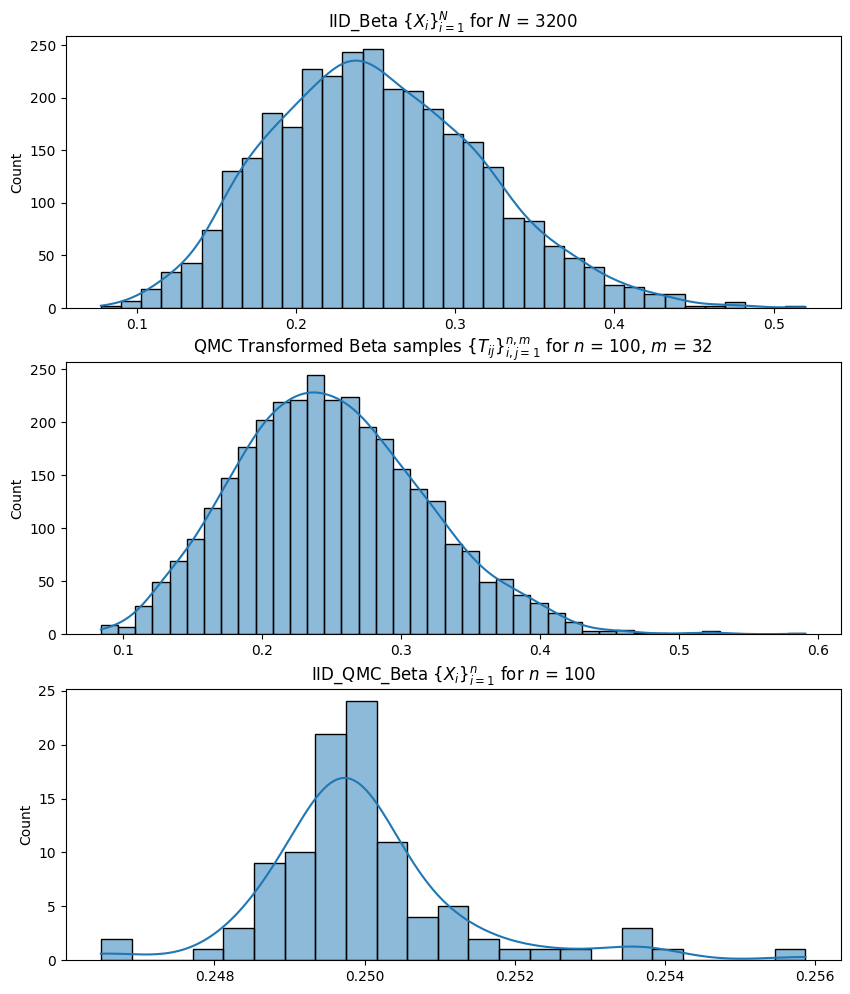

In [30]:
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

sns.histplot(x_iid, kde= True, ax=axs[0], edgecolor='black') # IID_Beta Hist and KDE
axs[0].set_title(f'IID_Beta {{$X_{{i}}$}}$_{{i=1}}^{{N}}$ for $N$ = {N}'); 

sns.histplot(beta_qmc, kde= True, ax=axs[1], edgecolor='black') # QMC Transformed Beta Samples Hist and KDE
axs[1].set_title(f'QMC Transformed Beta samples {{$T_{{ij}}$}}$_{{i,j=1}}^{{n,m}}$ for $n$ = {spawn_samples}, $m$ = {gen_samples}'); 

sns.histplot(x_qmc, kde= True, ax=axs[2], edgecolor='black') # IID_QMC_Beta Hist and KDE
axs[2].set_title(f'IID_QMC_Beta {{$X_{{i}}$}}$_{{i=1}}^{{n}}$ for $n$ = {spawn_samples}');


We note the following:
* The QMC Transformed Beta points (plot 2) make a smoother histogram than the IID_Beta points (plot 1).
* The $X_i$ from the IID_QMC_Beta points (plot 3) seem to have a heavy-tailed distribution.

## Simulation Plots

Here, we plot the confidence interval width as a function of sample size $N$ for IID_Beta and IID_QMC_Beta samples using the Hedged (Betting) CI method:

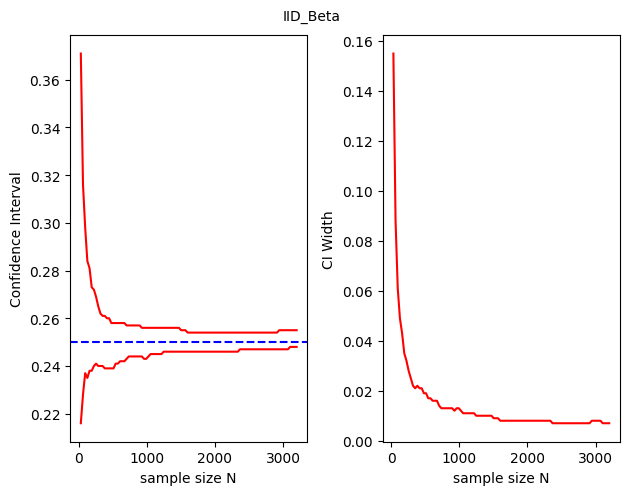

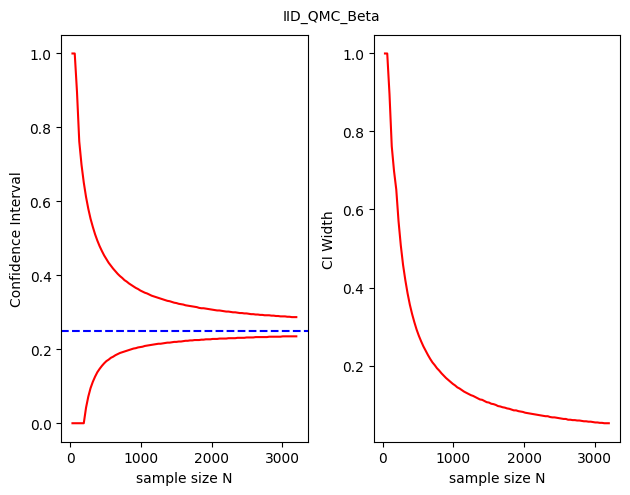

In [31]:
plot_func(times_iid,lower_bound_iid,upper_bound_iid,"IID_Beta") # IID_Beta Plot
plot_func(times_qmc * gen_samples,lower_bound_qmc,upper_bound_qmc,"IID_QMC_Beta") # IID_QMC_Beta Plot

## Printing the Simulation Output

Here, we print out the mean, std, upper bound, lower bound, Betting CI width, and CLT CI width for IID_Beta and IID_QMC_Beta based on a total of $N$ samples:


In [32]:
# Printing out the mean, std, upper bound, lower bound, Betting CI width, and CLT CI width for IID_Beta based on a total of N samples
print("IID_Beta mean for sample size N =", N, "is", x_iid.mean())
print("IID_Beta std for sample size N =", N, "is", x_iid.std())
print("IID_Beta Upper bound at sample size N =", N, "is", upper_bound_iid[len(upper_bound_iid) - 1])
print("IID_Beta Lower bound at sample size N =",N, "is", lower_bound_iid[len(lower_bound_iid) - 1])
print("IID_Beta Betting CI width at sample size N =",N, "is", upper_bound_iid[len(upper_bound_iid) - 1] - lower_bound_iid[len(lower_bound_iid) - 1])
print("The IID_Beta CLT CI width for sample size N =", N,"would be", norm.ppf(1 - alpha / 2) * x_iid.std() / np.sqrt(N))

print("")

# Printing out the mean, std, upper bound, lower bound, Betting CI width, and CLT CI width for IID_QMC_Beta based on a total of N samples
print("IID_QMC_Beta mean based on a total of N =", N, "is", x_qmc.mean())
print("IID_QMC_Beta std based on a total of N =", N, "is", x_qmc.std())
print("IID_QMC_Beta Upper bound based on a total of N =", N, "is", upper_bound_qmc[len(upper_bound_qmc) - 1])
print("IID_QMC_Beta Lower bound based on a total of N =", N, "is", lower_bound_qmc[len(lower_bound_qmc) - 1])
print("IID_QMC_Beta Betting CI width based on a total of N =", N, "is", upper_bound_qmc[len(upper_bound_qmc) - 1] - lower_bound_qmc[len(lower_bound_qmc) - 1])
print("The IID_QMC_Beta CLT CI width based on a total of N =", N,"would be", norm.ppf(1 - alpha / 2) * x_qmc.std() / np.sqrt(spawn_samples))

IID_Beta mean for sample size N = 3200 is 0.2516425526475378
IID_Beta std for sample size N = 3200 is 0.06737693498175273
IID_Beta Upper bound at sample size N = 3200 is 0.255
IID_Beta Lower bound at sample size N = 3200 is 0.248
IID_Beta Betting CI width at sample size N = 3200 is 0.007000000000000006
The IID_Beta CLT CI width for sample size N = 3200 would be 0.0023344487966042676

IID_QMC_Beta mean based on a total of N = 3200 is 0.24999892301082444
IID_QMC_Beta std based on a total of N = 3200 is 0.0013547078658965011
IID_QMC_Beta Upper bound based on a total of N = 3200 is 0.28700000000000003
IID_QMC_Beta Lower bound based on a total of N = 3200 is 0.23500000000000001
IID_QMC_Beta Betting CI width based on a total of N = 3200 is 0.05200000000000002
The IID_QMC_Beta CLT CI width based on a total of N = 3200 would be 0.00026551786267302595


Some further observations and questions:
* In both the IID_Beta and IID_QMC_Beta cases, the CI computed by the Hedged (Betting) method is wider than that computed by a CLT. Is this to be expected?
* The CLT CI width for IID_QMC_Beta is less than IID_Beta.
* In the case of IID_QMC_Beta, the CI computed by the Hedged (Betting) method is orders of magnitude larger than the CLT CI width for IID_QMC_Beta and larger than the Hedged (Betting) CI width for IID_Beta. Why is this? Could the heavy tailed distribution of IID_Beta_QMC samples (plot 3 of the Histogram and KDE distribution) explain it?

## Varying spawn_samples(n) and gen_samples(m)

Here, we vary the spawn_samples and gen_samples for IID_QMC_Beta while keeping their product a constant. Note that spawn_samples x gen_samples = N_vary. We will then identify the case where we get the minimum width for Betting CI and compare it to IID_Beta:

IID_Beta numerical experiments:

In [33]:
x_iid_vary = np.random.beta(beta_param[0], beta_param[1], N_vary) # The IID_Beta samples
lower_bound_iid_vary,upper_bound_iid_vary = betting_ci_seq(x_iid_vary, times=np.array([N_vary]), alpha=alpha, parallel=True, m_trunc=True, trunc_scale=3 / 4) 
    # Getting the sequential CI according to the code from the paper above
ci_iid_vary = upper_bound_iid_vary[0] - lower_bound_iid_vary[0] # The CI based on N_vary

Using 11 cores


IID_QMC_Beta numerical experiments:

In [34]:
ci_vector_qmc_vary = [] # The list of CIs for different gen_samples and spawn_samples
for i in range (len(spawn_samples_vary)):
    x_qmc_vary,beta_qmc_vary = gen_qmc_samples_iid(spawn_samples=spawn_samples_vary[i],gen_samples=gen_samples_vary[i]) # The IID_QMC_Beta samples
    lower_bound_qmc_vary,upper_bound_qmc_vary = betting_ci_seq(x_qmc_vary, times=np.array([spawn_samples_vary[i]]), alpha=alpha, parallel=True, m_trunc=True, trunc_scale=3 / 4) 
        # Getting the sequential CI according to the code from the paper above
    ci_vector_qmc_vary.append(upper_bound_qmc_vary[0] - lower_bound_qmc_vary[0]) # adding the current CI to the vector
ci_vector_qmc_vary = np.array(ci_vector_qmc_vary)


Using 11 cores
Using 11 cores
Using 11 cores
Using 11 cores
Using 11 cores
Using 11 cores
Using 11 cores
Using 11 cores
Using 11 cores
Using 11 cores
Using 11 cores


Here, we plot how the Betting CI width based on a total of N_vary changes as spawn_samples and gen_samples change:

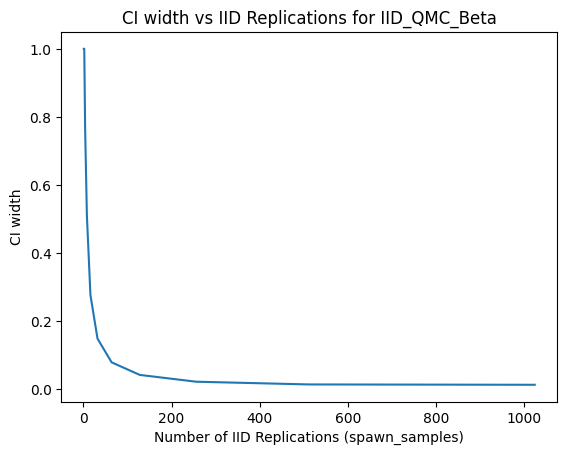

In [35]:
plt.plot(spawn_samples_vary,ci_vector_qmc_vary);
plt.xlabel("Number of IID Replications (spawn_samples)");
plt.ylabel("CI width");
plt.title("CI width vs IID Replications for IID_QMC_Beta");

Some further observations:
* The CI width tends to decrease as number of IID replication (spawn_samples) increases
* The plot looks asymptotic

Here, we print the spawn_samples size at which we get the minimum CI according to the Betting CI method and compare it to the width for IID_Beta:

In [36]:
min_ci_qmc = np.min(ci_vector_qmc_vary) # The smallest CI width for IID_QMC_Beta
min_ci_index_qmc = np.argmin(ci_vector_qmc_vary) # The index at which we get the smallest CI width for IID_QMC_Beta

print("IID_Beta Betting CI width at sample size N_vary =",N_vary, "is", ci_iid_vary)
print("")
print("IID_QMC_Beta Betting CI width based on sample size N_vary =",N_vary, "is lowest when spawn_samples =",spawn_samples_vary[min_ci_index_qmc],
      "and gen_samples =",gen_samples_vary[min_ci_index_qmc],"\nThe CI width for this spawn_samples and gen_samples is", min_ci_qmc)

IID_Beta Betting CI width at sample size N_vary = 1024 is 0.01100000000000001

IID_QMC_Beta Betting CI width based on sample size N_vary = 1024 is lowest when spawn_samples = 1024 and gen_samples = 1 
The CI width for this spawn_samples and gen_samples is 0.01200000000000001


Some further observations and questions:
* We get the least Betting CI width for IID_QMC_Beta when spawn_samples(n) = N_vary and gen_samples(m) = 1. This is probably expected.
* The IID_Beta Betting CI width is pretty similar to the least IID_QMC_Beta CI width.
* Does it make sense to use the betting method for QMC when we get the best result when we're only generating 1 QMC point per replication, and that gives similar results to IID_Beta?

# Integrand Problem of $f(X) = \frac{X e^X}{e}$

## Varying spawn_samples(n) and gen_samples(m)

Here, we vary the spawn_samples and gen_samples for IID replication of QMC samples while keeping their product a constant. Note that spawn_samples x gen_samples = N_vary. We will then identify the case where we get the minimum width for Betting CI and empirical Bernstein CI and compare it to IID. We will also compare the two CI methods:

IID numerical experiments:

In [37]:
iid = qp.IIDStdUniform(1,seed=7) # IID generator
x_iid_integrand = iid.gen_samples(N_vary).flatten()
y_iid_integrand = f(x_iid_integrand) 
lower_bound_iid_integrand_bet,upper_bound_iid_integrand_bet = betting_ci_seq(y_iid_integrand, times=np.array([N_vary]), alpha=alpha, parallel=True, m_trunc=True, trunc_scale=3 / 4) 
    # Getting the sequential Betting CI according to the code from the paper above
ci_iid_integrand_bet = upper_bound_iid_integrand_bet[0] - lower_bound_iid_integrand_bet[0] # The Betting CI based on N_vary
lower_bound_iid_integrand_eb,upper_bound_iid_integrand_eb = predmix_empbern_ci_seq(y_iid_integrand, times=np.array([N_vary]), alpha=alpha, parallel=True, truncation =1/2) 
    # Getting the sequential EB CI according to the code from the paper above
ci_iid_integrand_eb = upper_bound_iid_integrand_eb[0] - lower_bound_iid_integrand_eb[0] # The EB CI based on N_vary

Using 11 cores
Using 11 cores


IID replications of QMC experiments:

In [38]:
distribution=qp.DigitalNetB2(1,seed=7) # The QMC samples generator
ci_vector_qmc_integrand_bet = [] # The list of Betting CIs for different gen_samples and spawn_samples
ci_vector_qmc_integrand_eb = [] # The list of EB CIs for different gen_samples and spawn_samples
for i in range (len(spawn_samples_vary)):
    y_rld_means,y_rld = gen_qmc_samples_iid(distribution=distribution,spawn_samples=spawn_samples_vary[i],gen_samples=gen_samples_vary[i],function=f)
    lower_bound_qmc_integrand_bet,upper_bound_qmc_integrand_bet = betting_ci_seq(y_rld_means, times=np.array([spawn_samples_vary[i]]), alpha=alpha, parallel=True, m_trunc=True, trunc_scale=3 / 4) 
    # Getting the sequential Betting CI according to the code from the paper above
    ci_vector_qmc_integrand_bet.append(upper_bound_qmc_integrand_bet[0] - lower_bound_qmc_integrand_bet[0]) # adding the current Betting CI to the vector
    lower_bound_qmc_integrand_eb,upper_bound_qmc_integrand_eb = predmix_empbern_ci_seq(y_rld_means, times=np.array([spawn_samples_vary[i]]), alpha=alpha, parallel=True, truncation=1 / 2) 
    # Getting the sequential EB CI according to the code from the paper above
    ci_vector_qmc_integrand_eb.append(upper_bound_qmc_integrand_eb[0] - lower_bound_iid_integrand_eb[0]) # # adding the current EB CI to the vector
ci_vector_qmc_integrand_bet = np.array(ci_vector_qmc_integrand_bet)
ci_vector_qmc_integrand_eb = np.array(ci_vector_qmc_integrand_eb)


Using 11 cores
Using 11 cores
Using 11 cores
Using 11 cores
Using 11 cores
Using 11 cores
Using 11 cores
Using 11 cores
Using 11 cores
Using 11 cores
Using 11 cores
Using 11 cores
Using 11 cores
Using 11 cores
Using 11 cores
Using 11 cores
Using 11 cores
Using 11 cores
Using 11 cores
Using 11 cores
Using 11 cores
Using 11 cores


Here, we plot how the Betting CI and EB CI width based on a total of N_vary changes as spawn_samples and gen_samples change:

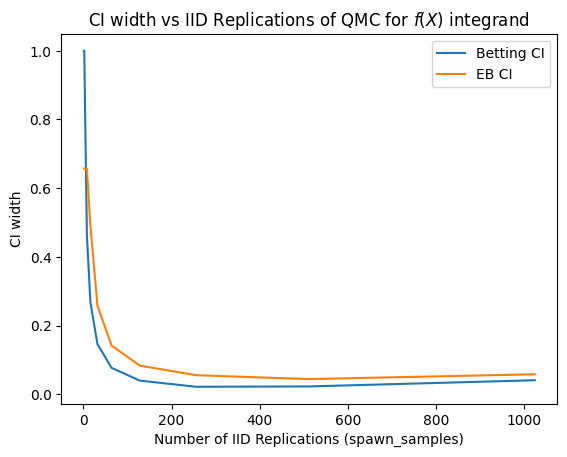

In [39]:
plt.plot(spawn_samples_vary,ci_vector_qmc_integrand_bet, label = "Betting CI");
plt.plot(spawn_samples_vary,ci_vector_qmc_integrand_eb, label = "EB CI");
plt.xlabel("Number of IID Replications (spawn_samples)");
plt.ylabel("CI width");
plt.title("CI width vs IID Replications of QMC for $f(X)$ integrand");
plt.legend();

Some further observations:
* The CI width for both methods initially tends to decrease as number of IID replication (spawn_samples) increases but tends to slightly increase later
* EB CI performs better initially (low IID Replication) but as IID replications increase, Betting CI performs better

Here, we print the spawn_samples and gen_samples size at which we get the minimum CI according to the Betting and EB CI method and compare it to the width for IID:

In [40]:
min_ci_qmc_bet = np.min(ci_vector_qmc_integrand_bet) # The smallest Betting CI width for IID replications of QMC
min_ci_index_qmc_bet = np.argmin(ci_vector_qmc_integrand_bet) # The index at which we get the smallest Betting CI width for IID Replications of QMC
min_ci_qmc_eb = np.min(ci_vector_qmc_integrand_eb) # The smallest EB CI width for IID replications of QMC
min_ci_index_qmc_eb = np.argmin(ci_vector_qmc_integrand_eb) # The index at which we get the smallest EB CI width for IID Replications of QMC

print("IID Betting CI width at sample size N_vary =",N_vary, "is", ci_iid_integrand_bet)
print("IID EB CI width at sample size N_vary =",N_vary, "is", ci_iid_integrand_eb)
print("")
print("IID Replications of QMC Betting CI width based on sample size N_vary =",N_vary, "is lowest when spawn_samples =",spawn_samples_vary[min_ci_index_qmc_bet],
      "and gen_samples =",gen_samples_vary[min_ci_index_qmc_bet],"\nThe CI width for this spawn_samples and gen_samples is", min_ci_qmc_bet)
print("")
print("IID Replications of QMC EB CI width based on sample size N_vary =",N_vary, "is lowest when spawn_samples =",spawn_samples_vary[min_ci_index_qmc_eb],
      "and gen_samples =",gen_samples_vary[min_ci_index_qmc_eb],"\nThe CI width for this spawn_samples and gen_samples is", min_ci_qmc_eb)

IID Betting CI width at sample size N_vary = 1024 is 0.045999999999999985
IID EB CI width at sample size N_vary = 1024 is 0.05510102333457373

IID Replications of QMC Betting CI width based on sample size N_vary = 1024 is lowest when spawn_samples = 256 and gen_samples = 4 
The CI width for this spawn_samples and gen_samples is 0.02200000000000002

IID Replications of QMC EB CI width based on sample size N_vary = 1024 is lowest when spawn_samples = 512 and gen_samples = 2 
The CI width for this spawn_samples and gen_samples is 0.04438557585801589


Some further observations:
* The CIs through IID replications of QMC perform better than IID
* Betting CI performs better than EB CI

## Not varying spawn_samples(n) and gen_samples(m)

Here, we will use the spawn_samples and gen_samples size at which we obtained the minimum Betting CI width for IID replications of QMC from the previous integrand experiment.

Here, we set the num_times, spawn_samples, gen_samples, and N

In [41]:
num_times = spawn_samples_vary[min_ci_index_qmc_bet] #number of different times where CI will be computed
spawn_samples = num_times * space_times # The number of IID replications for low discrepancy or QMC samples (n)
gen_samples = gen_samples_vary[min_ci_index_qmc_bet] # The number of low discrepancy or QMC samples generated per replication (m)
N = spawn_samples * gen_samples # The maxmimum sample size (N = mn)

IID numerical experiments:

In [42]:
times_iid_integrand = (space_times * np.arange(1,num_times+1)) * gen_samples # The times (sample sizes) for which we'll compute the lower and upper bounds on the confidence intervals
iid_fixed = qp.IIDStdUniform(1,seed=7) # IID generator
x_iid_integrand_fixed = iid_fixed.gen_samples(N).flatten()
y_iid_integrand_fixed = f(x_iid_integrand_fixed) 
lower_bound_iid_integrand_bet_fixed,upper_bound_iid_integrand_bet_fixed = betting_ci_seq(y_iid_integrand_fixed, times=times_iid_integrand, alpha=alpha, parallel=True, m_trunc=True, trunc_scale=3 / 4) 
    # Getting the sequential Betting CI according to the code from the paper above
ci_iid_integrand_bet_fixed = upper_bound_iid_integrand_bet_fixed - lower_bound_iid_integrand_bet_fixed # The Betting CIs for different times in time_iid_integrand
lower_bound_iid_integrand_eb_fixed,upper_bound_iid_integrand_eb_fixed = predmix_empbern_ci_seq(y_iid_integrand_fixed, times=times_iid_integrand, alpha=alpha, parallel=True, truncation =1/2) 
    # Getting the sequential EB CI according to the code from the paper above
ci_iid_integrand_eb_fixed = upper_bound_iid_integrand_eb_fixed - lower_bound_iid_integrand_eb_fixed # The EB CIs for different times in time_iid_integrand

Using 11 cores
Using 11 cores


IID replications of QMC experiments:

In [43]:
times_qmc_integrand = space_times * np.arange(1,num_times+1) # The times (sample sizes) for which we'll compute the lower and upper bound values
y_rld_means_integrand,y_rld_integrand = gen_qmc_samples_iid(distribution=qp.DigitalNetB2(1,seed=7),spawn_samples=spawn_samples,gen_samples=gen_samples,function=f)
lower_bound_qmc_integrand_bet_fixed,upper_bound_qmc_integrand_bet_fixed = betting_ci_seq(y_rld_means_integrand, times=times_qmc_integrand, alpha=alpha, parallel=True, m_trunc=True, trunc_scale=3 / 4) 
    # Getting the sequential Betting CI according to the code from the paper above
ci_qmc_integrand_bet_fixed = upper_bound_qmc_integrand_bet_fixed - lower_bound_qmc_integrand_bet_fixed # The Betting CIs for different times in time_qmc_integrand
lower_bound_qmc_integrand_eb_fixed,upper_bound_qmc_integrand_eb_fixed = predmix_empbern_ci_seq(y_rld_means_integrand, times=times_qmc_integrand, alpha=alpha, parallel=True, truncation=1 / 2) 
    # Getting the sequential EB CI according to the code from the paper above
ci_qmc_integrand_eb_fixed = upper_bound_qmc_integrand_eb_fixed - lower_bound_qmc_integrand_eb_fixed # The EB CIs for different times in time_qmc_integrand

Using 11 cores
Using 11 cores


## Simulation Plots

Here, we plot the confidence interval width as a function of sample size $N$ for IID and IID replications of QMC using the Hedged (Betting) and EB CI method:

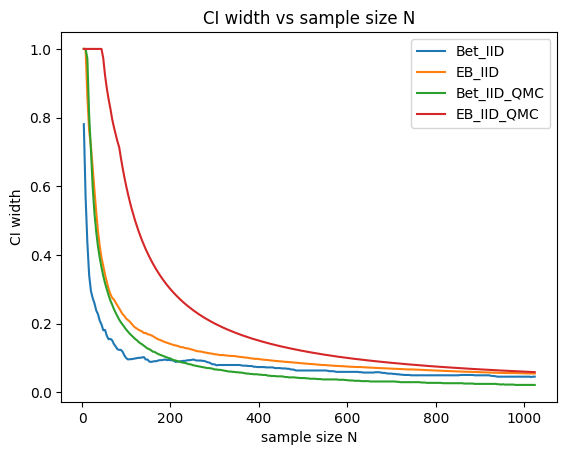

In [44]:
plt.plot(times_iid_integrand,ci_iid_integrand_bet_fixed,label = "Bet_IID");
plt.plot(times_iid_integrand,ci_iid_integrand_eb_fixed,label = "EB_IID");
plt.plot(times_qmc_integrand * gen_samples,ci_qmc_integrand_bet_fixed,label = "Bet_IID_QMC");
plt.plot(times_qmc_integrand * gen_samples,ci_qmc_integrand_eb_fixed,label = "EB_IID_QMC");
plt.ylabel("CI width");
plt.xlabel("sample size N");
plt.legend();
plt.title("CI width vs sample size N");

Some further observations:
* Bet_IID_QMC performs the best after some time
* The other three (excluding Bet_IID_QMC) approach a similar value at sample size $N$